In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Training EfficientNet model on imbalanced data

<b> Lets check the specs of my GPU on which this model has been trained on.

In [2]:
!nvidia-smi

Thu Dec  8 05:42:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing the dependencies

In [3]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Loading training, validation and testing dataset

In [4]:
train_data_dir = r"/content/gdrive/MyDrive/FYP Training Models/Covid-19 Dataset/Train"
validation_data_dir = r"/content/gdrive/MyDrive/FYP Training Models/Covid-19 Dataset/Validation"
test_data_dir = r"/content/gdrive/MyDrive/FYP Training Models/Covid-19 Dataset/Test"

In [5]:
n_classes = os.listdir(train_data_dir)
print("The total number of classes present in the dataset are: ", n_classes)

The total number of classes present in the dataset are:  ['Covid', 'Normal', 'Viral Pneumonia']


## Looking at some individual samples from training data

In [6]:
from PIL import Image

In [8]:
# loading the first sample from Covid class

covid_sample1 = os.listdir(train_data_dir+'/Covid')[0]
covid_sample1 = os.path.join(train_data_dir+"/Covid", covid_sample1)

print("Covid")
Image.open(covid_sample1)

In [ ]:
# loading the first sample from Normal class

normal_sample1 = os.listdir(train_data_dir+r'/Normal')[0]
normal_sample1 = os.path.join(train_data_dir+r"/Normal", normal_sample1)

print("Normal")
Image.open(normal_sample1)

Viral Pneumonia


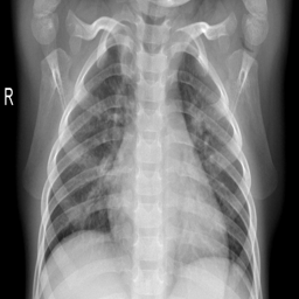

In [ ]:
# loading the first sample from Viral Pneumonia class

pneumonia_sample1 = os.listdir(train_data_dir+r'/Viral Pneumonia')[0]
pneumonia_sample1 = os.path.join(train_data_dir+r"/Viral Pneumonia", pneumonia_sample1)

print("Viral Pneumonia")
Image.open(pneumonia_sample1)

## Performing preprocessing on training, validation and testing images

Since I will be training 3 GAN architectures, DCGAN, WGAN, and WGAN-GP, on 1*64*64 images, I will need to resize all my images to same dimension in order to compare the performance of the model accross all datasets. However, the model I have selected, <b> ResNet-50 </b> takes an input image of 3 * 224 * 244. The number of channels can be changed to 1 in the input layer indicating that the model takes in greyscale image. However, we have two options related to the input image dimensions:

    1. Delete/Modify original model such that the initial layers take in 64 * 64 images.
    2. Or, perform zero-padding on all training images and convert their dimensions from 1 * 64 * 64 to 1 * 224 * 224.
    
    
I must also note that after generating 1 * 64 * 64 images from GANs, I would need to perform same padding on those images to match the dimensions. This way, we can fairly compare the performance of <b> ResNet-50 </b> accross 


    1. Imbalanced data
    2. Data with traditional augmentation
    3. Data with DCGAN augmentation
    4. Data with WGAN augmentation
    5. Data with WGAN-GP augmentation

### Calculating mean and standard deviation of the channels of our training dataset

We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [9]:
# creating the train dataset and dataloader for calculating the mean and standard deviation of our samples
image_size = 64
batch_size = 100
CHANNELS_IMG = 1

In [ ]:
train_ds = ImageFolder(train_data_dir, transform=tt.Compose([
                                        tt.Grayscale(num_output_channels=1),
                                        tt.Resize(image_size),
                                        tt.ToTensor()]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
mean, std = get_mean_and_std(train_dl)

In [ ]:
print("The calculated mean is: ", mean)
print("The calculated standard deviation is: ", std)

The calculated mean is:  tensor([0.5184])
The calculated standard deviation is:  tensor([0.2531])


Mean = 0.5184, Std = 0.2531

### Creating datasets and dataloaders with normalization and zero-padding

In [10]:
mean = 0.5184
std = 0.2531

stats = [mean for _ in range(CHANNELS_IMG)], [std for _ in range(CHANNELS_IMG)];stats

([0.5184], [0.2531])

In [11]:
from PIL import Image
import glob

In [12]:
class CustomDatasetWithPadding(Dataset):
    def __init__(self, data_dir, transforms):
        self.data = []
        self.transform = transforms
        self.targets = []
    
        class_list = os.listdir(data_dir) # ['Covid', 'Normal', 'Viral Pneumonia']
        for class_name in class_list:
            class_path = os.path.join(data_dir, class_name)
            for img_path in glob.glob(class_path + "/*.png"):
                self.data.append([img_path, class_name])
                
        self.available_classes = os.listdir(data_dir)
                        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = self.transform(Image.open(img_path))
        grey_image = np.zeros([1, 224, 224], dtype = np.float64)
        grey_image[:,80:144, 80:144] = img
        grey_image = torch.from_numpy(grey_image)
        grey_image = grey_image.type(torch.FloatTensor)
        # grey_image = grey_image.type(torch.cuda.FloatTensor)
        
        class_id = self.available_classes.index(class_name)
        class_id = torch.tensor(class_id)
        
        
        return grey_image, class_id

In [13]:
# following transformations will be performed on each image
transformations_to_perform = transform=tt.Compose([
                                tt.Grayscale(num_output_channels=1),
                                tt.Resize(image_size),
                                tt.ToTensor(),
                                tt.Normalize(*stats)])


# Training dataset
train_ds = CustomDatasetWithPadding(train_data_dir, transformations_to_perform)
train_dl = DataLoader(train_ds, batch_size, shuffle=True,  pin_memory=True)

# Validation dataset
val_ds = CustomDatasetWithPadding(validation_data_dir, transformations_to_perform)
val_dl = DataLoader(val_ds, batch_size, shuffle=True, pin_memory=True)


# Test dataset
test_ds = CustomDatasetWithPadding(test_data_dir, transformations_to_perform)
test_dl = DataLoader(test_ds, batch_size, shuffle=True, pin_memory=True)

In [14]:
# custom function for denormalizing normalized images 

def denorm(img_tensors):
    img = img_tensors[:,80:144, 80:144] 
    img = img * stats[1][0] + stats[0][0]
    img_tensors[:,80:144, 80:144]  = img
    return img_tensors

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


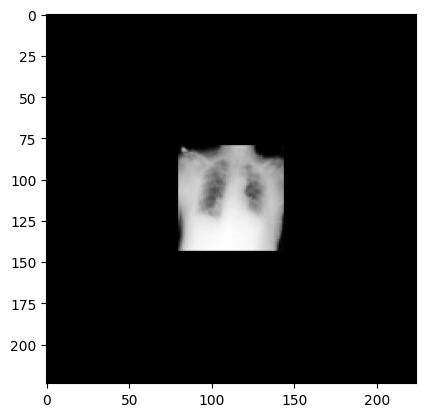

In [ ]:
# Padded image 1
print(train_ds[0][0])
plt.imshow(denorm(train_ds[0][0])[0], cmap ='gray')

# Using a GPU

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
# transporting training, validation and testing dataloaders to GPU

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# Importing EfficientNet Model

In [ ]:
# importing our custom EfficientNet

# from modell import EfficientNet1, CNNBlock, SqueezeExcitation, InvertedResidualBlock

In [18]:
from EfficientNet import EfficientNetModel, CNNBlock, SqueezeExcitation, InvertedResidualBlock

In [19]:
version = "b0"
num_classes = 3
model = EfficientNetModel(version, num_classes)
model = to_device(model, device)

# Training our model

In [20]:
from tqdm import tqdm

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
%%time

history = [evaluate(model, val_dl)]
history

CPU times: user 9.09 s, sys: 1.23 s, total: 10.3 s
Wall time: 9min 36s


[{'val_loss': 1.0986835956573486, 'val_acc': 33.33333206176758}]

In [23]:
epochs = 20
max_lr =  0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [24]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

100%|██████████| 128/128 [2:05:31<00:00, 58.84s/it]


Epoch [0], last_lr: 0.00001, train_loss: 1.0595, val_loss: 1.0579, val_acc: 44.7500


100%|██████████| 128/128 [02:03<00:00,  1.04it/s]


Epoch [1], last_lr: 0.00003, train_loss: 0.8213, val_loss: 1.0132, val_acc: 47.0833


100%|██████████| 128/128 [02:04<00:00,  1.03it/s]


Epoch [2], last_lr: 0.00005, train_loss: 0.5538, val_loss: 0.9217, val_acc: 54.0833


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [3], last_lr: 0.00008, train_loss: 0.4050, val_loss: 0.6929, val_acc: 71.4167


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [4], last_lr: 0.00009, train_loss: 0.3024, val_loss: 0.8335, val_acc: 68.8333


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [5], last_lr: 0.00010, train_loss: 0.2351, val_loss: 0.4989, val_acc: 80.5000


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [6], last_lr: 0.00010, train_loss: 0.1750, val_loss: 0.4837, val_acc: 82.8333


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [7], last_lr: 0.00010, train_loss: 0.1366, val_loss: 0.4079, val_acc: 85.0833


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [8], last_lr: 0.00009, train_loss: 0.1137, val_loss: 0.5593, val_acc: 81.0000


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [9], last_lr: 0.00008, train_loss: 0.0959, val_loss: 0.4319, val_acc: 86.5000


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [10], last_lr: 0.00007, train_loss: 0.0810, val_loss: 0.5079, val_acc: 84.3333


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [11], last_lr: 0.00006, train_loss: 0.0622, val_loss: 0.5488, val_acc: 84.9167


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [12], last_lr: 0.00005, train_loss: 0.0615, val_loss: 0.5742, val_acc: 84.1667


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [13], last_lr: 0.00004, train_loss: 0.0405, val_loss: 0.5087, val_acc: 86.3333


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [14], last_lr: 0.00003, train_loss: 0.0404, val_loss: 0.6321, val_acc: 82.9167


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [15], last_lr: 0.00002, train_loss: 0.0353, val_loss: 0.4706, val_acc: 87.7500


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [16], last_lr: 0.00001, train_loss: 0.0315, val_loss: 0.5139, val_acc: 86.9167


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [17], last_lr: 0.00000, train_loss: 0.0264, val_loss: 0.5232, val_acc: 86.5000


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [18], last_lr: 0.00000, train_loss: 0.0253, val_loss: 0.5243, val_acc: 86.9167


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [19], last_lr: 0.00000, train_loss: 0.0249, val_loss: 0.5278, val_acc: 86.5000
CPU times: user 25min 54s, sys: 13min 52s, total: 39min 46s
Wall time: 2h 47min 18s


In [25]:
import pickle

with open('history_Imbalanced.pkl', 'wb') as f:
       pickle.dump(history, f)

In [26]:
torch.save(model.state_dict(), 'EfficientNet_Imbalanced.pth')

In [27]:
!cp '/content/EfficientNet_Imbalanced.pth' '/content/gdrive/MyDrive/FYP Training Models'